# Customer Segmentation

## Background

This dataset contains all purchases made for an online retail company based in the UK during an eight month period. We could use cluster analysis combined with RFM analysis to do a customer segmentation.

## Prepare and Explore the Data

For this experiment, we will use [this](https://www.kaggle.com/vijayuv/onlineretail) data from Kaggle platform.

In [ ]:
# Package imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', None)

In [ ]:
# Load data
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Since we want to segment our customers, we have to make sure that `CustomerID` is not null.

In [ ]:
# Check missing value
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

We could see that there is missing value in `CustomerID` columns. We could remove those missing values.

In [ ]:
# Remove missing value
df = df[df["CustomerID"].notna()]

df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Then we could do some descriptive statistic.

In [ ]:
# Simple descriptive statistic
df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


Wait, hold on. How come the quantity is a negative number and the unit price is zero? Let's check it.

In [ ]:
# Check anomaly data
quantity_zero = len(df[df["Quantity"] <= 0])
perc_quantity_zero = (len(df[df["Quantity"] <= 0]) / len(df)) * 100
unitprice_zero = len(df[df["UnitPrice"] == 0])
perc_unitprice_zero = (len(df[df["UnitPrice"] == 0]) / len(df)) * 100

print("The data consist of", str(quantity_zero), "rows of data with item quantity less/equal than zero.")
print("About {:.2f}% of total data".format(perc_quantity_zero))
print("")
print("The data consist of", str(unitprice_zero), "rows of data with unit price equal to zero.")
print("About {:.2f}% of total data".format(perc_unitprice_zero))

The data consist of 8905 rows of data with item quantity less/equal than zero.
About 2.19% of total data

The data consist of 40 rows of data with unit price equal to zero.
About 0.01% of total data


Then just remove those anomaly data

In [ ]:
# Remove anomaly
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,397884.000000,397884.000000
mean,12.988238,3.116488
std,179.331775,22.097877
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


Now we're good to go. Lets do some data exploration!

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


The data contains 406829 rows and 8 columns, each row represents each item in a purchasement. The columns are:
* `InvoiceNo` - Invoice number, to identify each invoice
* `StockCode` - Stock code, to identify each item in the inventory
* `Description` - Item's description
* `Quantity` - Number of purchased item in each invoice
* `InvoiceDate` - Date of purchasement
* `UnitPrice` - Item's price per unit
* `CustomerID` - Customer's identification number
* `Country` - Customer's country of origin

In [ ]:
# Check unique value
df[['InvoiceNo', 'StockCode', 'CustomerID', 'Country']].nunique()

InvoiceNo     18532
StockCode      3665
CustomerID     4338
Country          37
dtype: int64

There are 18532 purchasements, 3665 unique item purchased, from 4338 customers that came from 37 countries.

As we seen above, there are 37 countries of customer's origin. Since the retail company is based in the UK, we could simplified the country as UK or Non UK

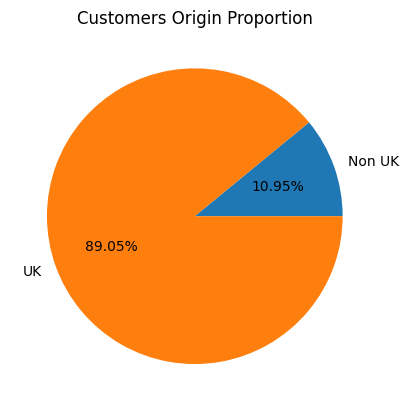

In [ ]:
# Simplify country origin
df['Country_isUK'] = np.where(df['Country']=='United Kingdom', 'UK', 'Non UK')

customers_origin = df.groupby(['Country_isUK']).size()

plt.title('Customers Origin Proportion')
plt.pie(customers_origin, labels=customers_origin.index, autopct=lambda p: f'{p:.2f}%')
plt.show();

Based on the piechart, we could see that mostly our customers are from the UK.

Next, we could analyze the trend of purchasement. First, lets create `TotalAmount` column (`Quantity` * `UnitPrice`). Then, we could transform the `InvoiceDate` data type from string to date.

In [ ]:
# Create new features and cast date column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34


Then plot the trendline.

In [ ]:
import matplotlib.dates as mdates

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option i

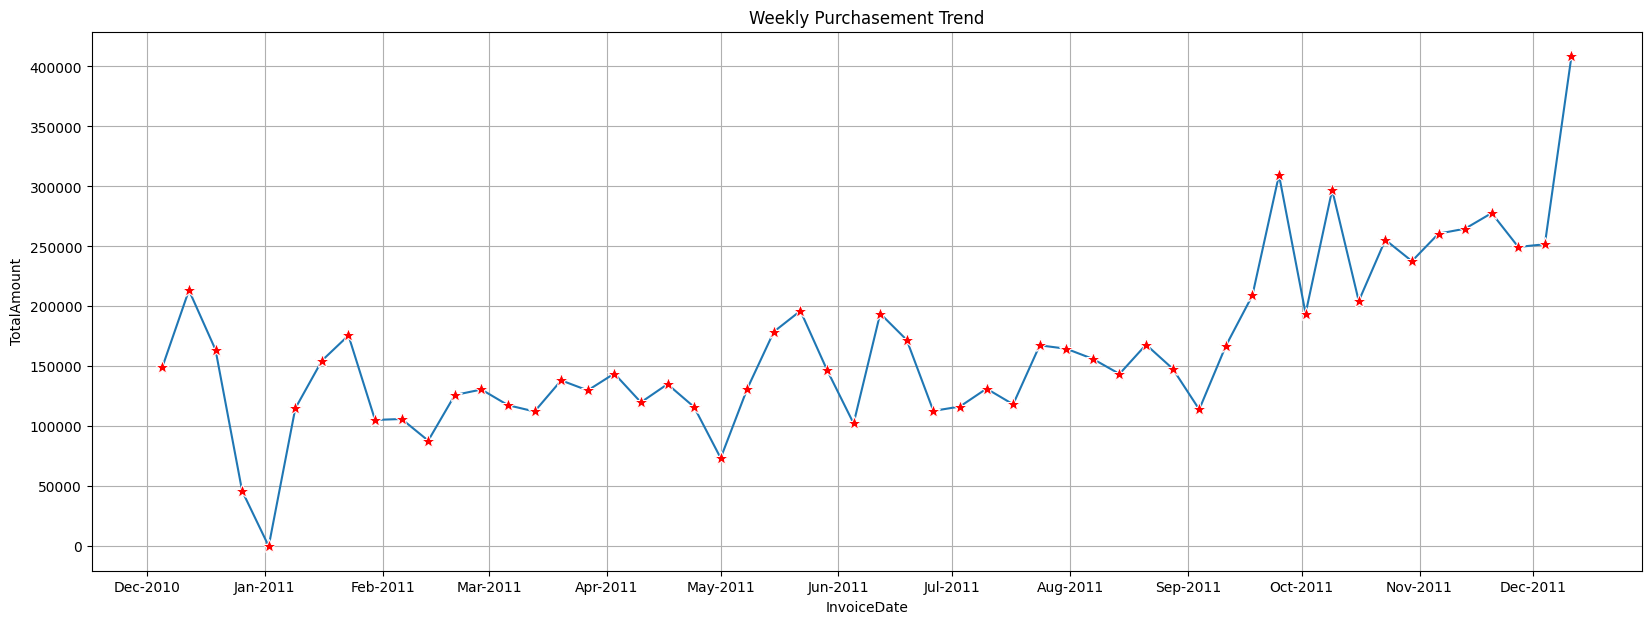

In [ ]:
# Plot weekly trend
weekly_purchasements = df.copy()
weekly_purchasements = weekly_purchasements.groupby(
    by=pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Weekly Purchasement Trend')
ax = sns.lineplot(
    x=weekly_purchasements.index,
    y=weekly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option i

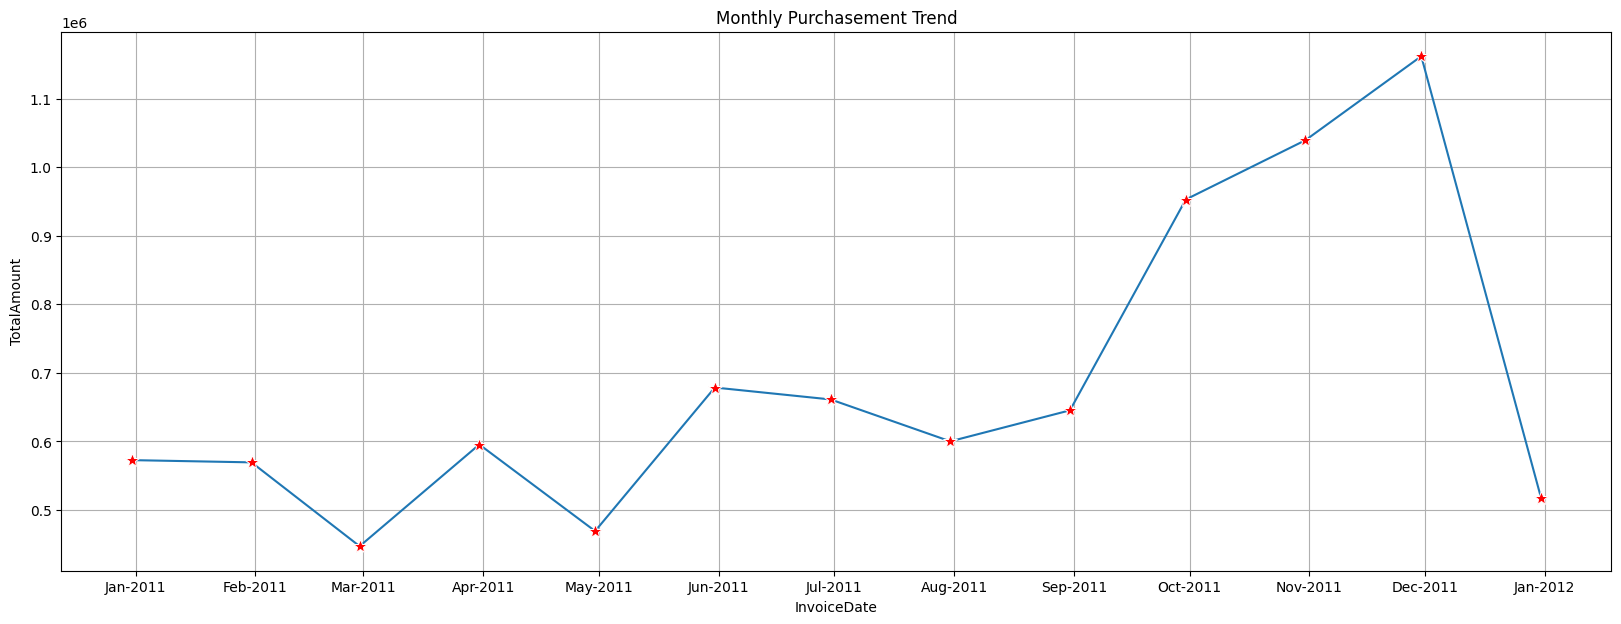

In [ ]:
# Plot monthly trend
monthly_purchasements = df.copy()
monthly_purchasements = monthly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Monthly Purchasement Trend')
ax = sns.lineplot(
    x=monthly_purchasements.index,
    y=monthly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

Based on the picture above, it can be seen that there was an increase in total purchases at the end of the year.

## RFM

In this project, we would segment the customers using customer's demography and purchasement behavior. To explain the customer's demography, we could use `Country` column while to explain the customer's purchasement behavior we have to transform our data first to get those information. We could use RFM analysis to get those information.

### Recency

To measure customer's recency, we could substract the latest transaction date in the data with each customer's latest transaction.

In [ ]:
# Get customer's recency
recency = df.groupby(['CustomerID'])['InvoiceDate'].max()
recency = max(recency) - recency
recency = recency.dt.days
recency = recency.rename('Recency')
recency.head()

CustomerID
12346.0    325
12347.0      1
12348.0     74
12349.0     18
12350.0    309
Name: Recency, dtype: int64

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


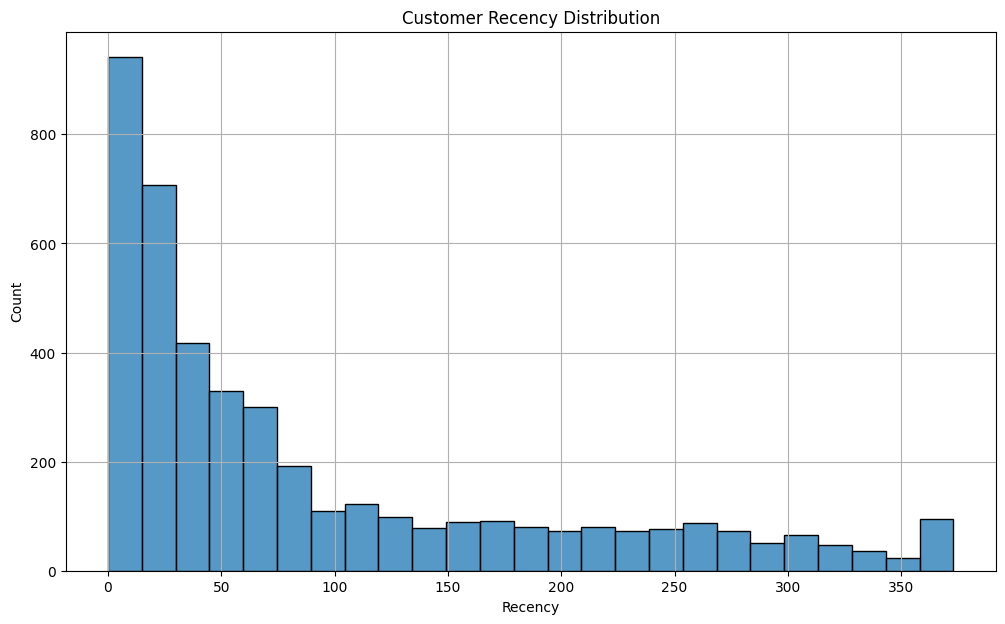

In [ ]:
# Recency histogram plot
plt.figure(figsize=(12, 7))
sns.histplot(recency)
plt.title('Customer Recency Distribution')
plt.grid()
plt.show()

### Frequency

To measure customer's frequency, we could count customer's invoice.

In [ ]:
# Count frequency
frequency = df.groupby(['CustomerID'])['InvoiceNo'].count()
frequency = frequency.rename('Frequency')
frequency.head()

CustomerID
12346.0      1
12347.0    182
12348.0     31
12349.0     73
12350.0     17
Name: Frequency, dtype: int64

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


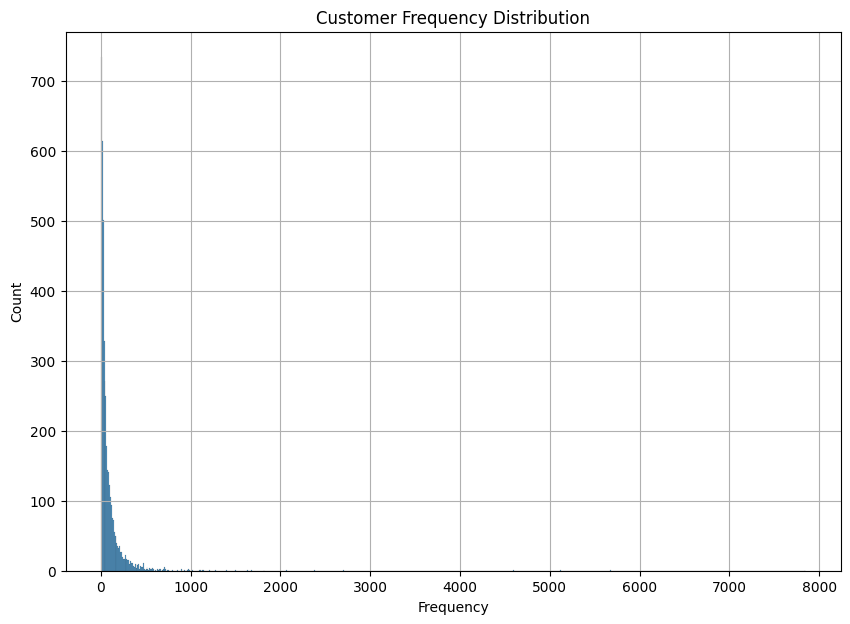

In [ ]:
# Frequency histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Frequency Distribution')
sns.histplot(frequency)
plt.grid()
plt.show();

### Monetary

To measure customer's monetary, we could sum the customer's total purchasements.

In [ ]:
# Sum the money spent
monetary = df.groupby(['CustomerID'])['TotalAmount'].sum()
monetary = monetary.rename('Monetary Spent')
monetary.head()

CustomerID
12346.0    77183.60
12347.0     4310.00
12348.0     1797.24
12349.0     1757.55
12350.0      334.40
Name: Monetary Spent, dtype: float64

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


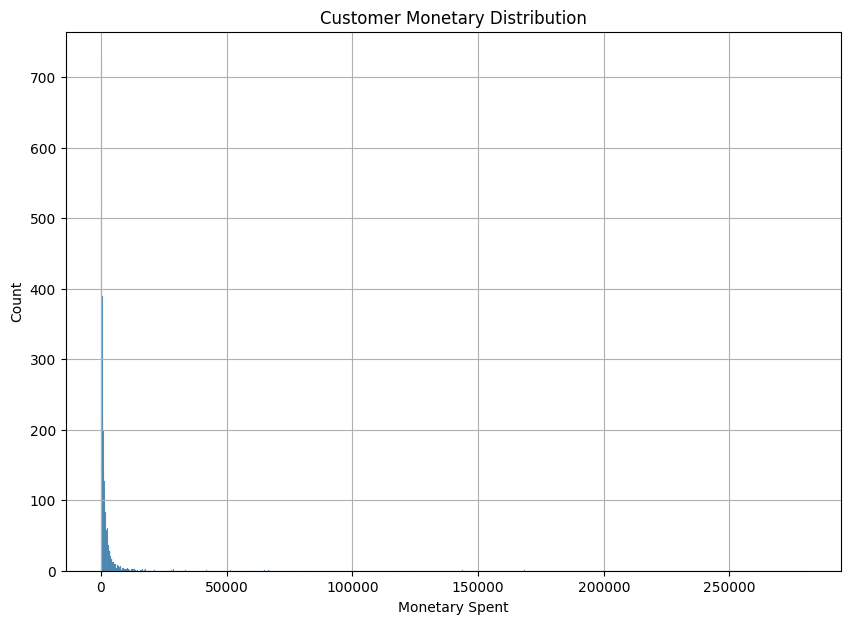

In [ ]:
# Monetary histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Monetary Distribution')
sns.histplot(monetary)
plt.grid()
plt.show()

### Merge the Data

The data could be separated into two dataframes. The first dataframe (log transformed data) supposed to be used when modeling and the second one (without log transformation) could be used when visualize the result.

In [ ]:
# Get customer's country of origin
country = (
    df.groupby(['CustomerID', 'Country_isUK'])
    .size()
    .reset_index()
    .drop(0, axis=1)
)#chaining method

# Merge the data
df_new = (
    country
    .merge(recency,on='CustomerID')
    .merge(frequency,on='CustomerID')
    .merge(monetary,on='CustomerID')
)

# Set CustomerID as index
df_new = df_new.set_index('CustomerID')
df_new.head()

,Country_isUK,Recency,Frequency,Monetary Spent
CustomerID,,,,
12346.0,UK,325,1,77183.60
12347.0,Non UK,1,182,4310.00
12348.0,Non UK,74,31,1797.24
12349.0,Non UK,18,73,1757.55
12350.0,Non UK,309,17,334.40


### One Hot Encoding

Since our model could just accept the numeric value, we have to recode the non numeric column.

In [ ]:
# Recode the non numeric variable

df_new = pd.get_dummies(
    df_new,
    columns=['Country_isUK'],
    drop_first=True
)

df_new = df_new.rename(
    columns={'Country_isUK_UK': 'Country_UK'}
)

df_new.head()

,Recency,Frequency,Monetary Spent,Country_UK
CustomerID,,,,
12346.0,325,1,77183.60,True
12347.0,1,182,4310.00,False
12348.0,74,31,1797.24,False
12349.0,18,73,1757.55,False
12350.0,309,17,334.40,False


### Scaling

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

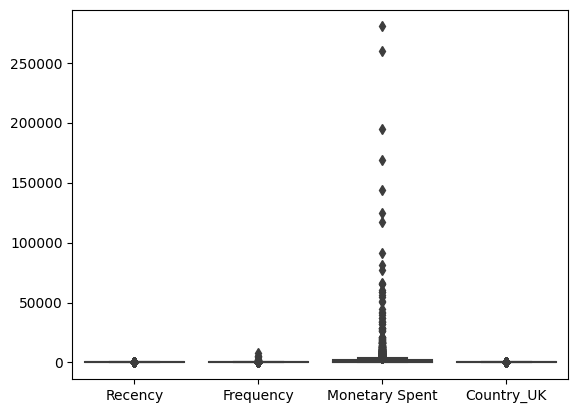

In [ ]:
sns.boxplot(data=df_new)
plt.show()

As we could see, there are variation of range in each column. We have to standardize it first.

In [ ]:
# Scale the data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new)

df_scaled = pd.DataFrame(
    df_scaled,
    columns=df_new.columns,
    index=df_new.index
)

df_scaled.head()

,Recency,Frequency,Monetary Spent,Country_UK
CustomerID,,,,
12346.0,2.334574,-0.396578,8.358668,0.326547
12347.0,-0.905340,0.394649,0.250966,-3.062350
12348.0,-0.175360,-0.265435,-0.028596,-3.062350
12349.0,-0.735345,-0.081836,-0.033012,-3.062350
12350.0,2.174578,-0.326635,-0.191347,-3.062350


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

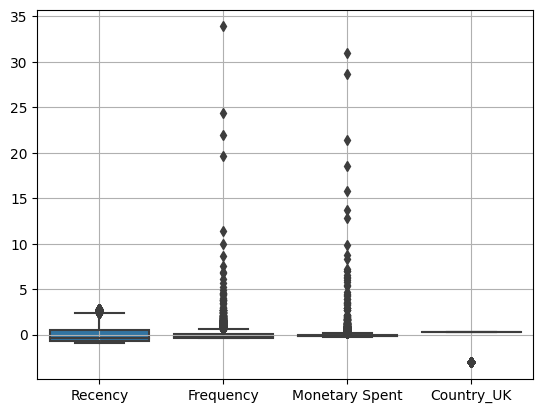

In [ ]:
# Plot scaled data
sns.boxplot(data = df_scaled)
plt.grid()
plt.show()

## Modeling

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Modeling
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette = []

for k in possible_k:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_scaled)
    silhouette.append(silhouette_score(X=df_scaled, labels=kmeans.labels_))

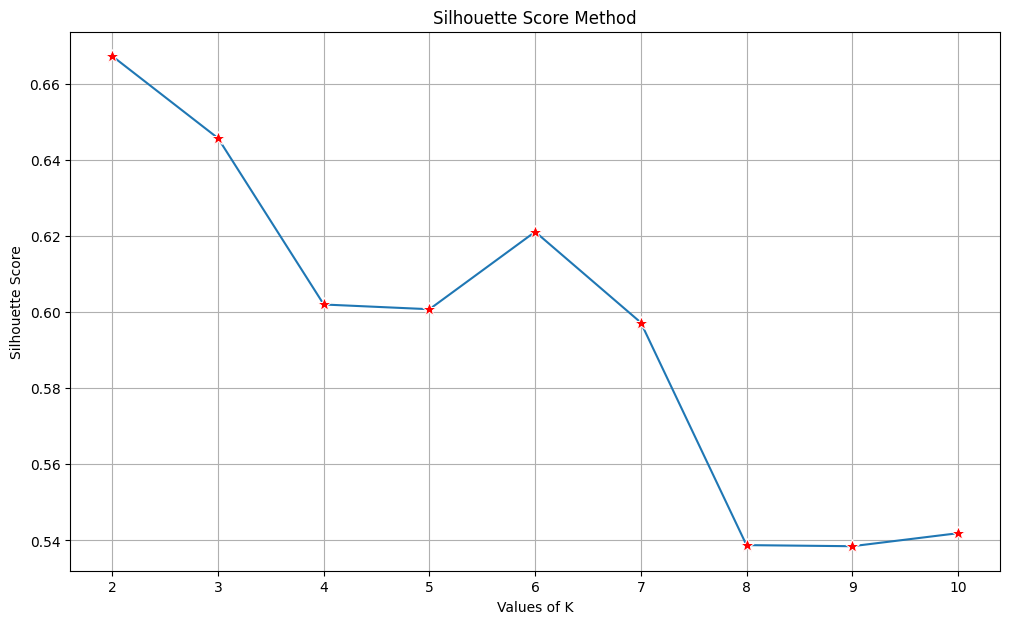

In [ ]:
# Plot the score
plt.figure(figsize=(12, 7))
sns.lineplot(
    x=possible_k,
    y=silhouette,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.grid()
plt.show();

Using silhouette score, the best K is either 2 or 6

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


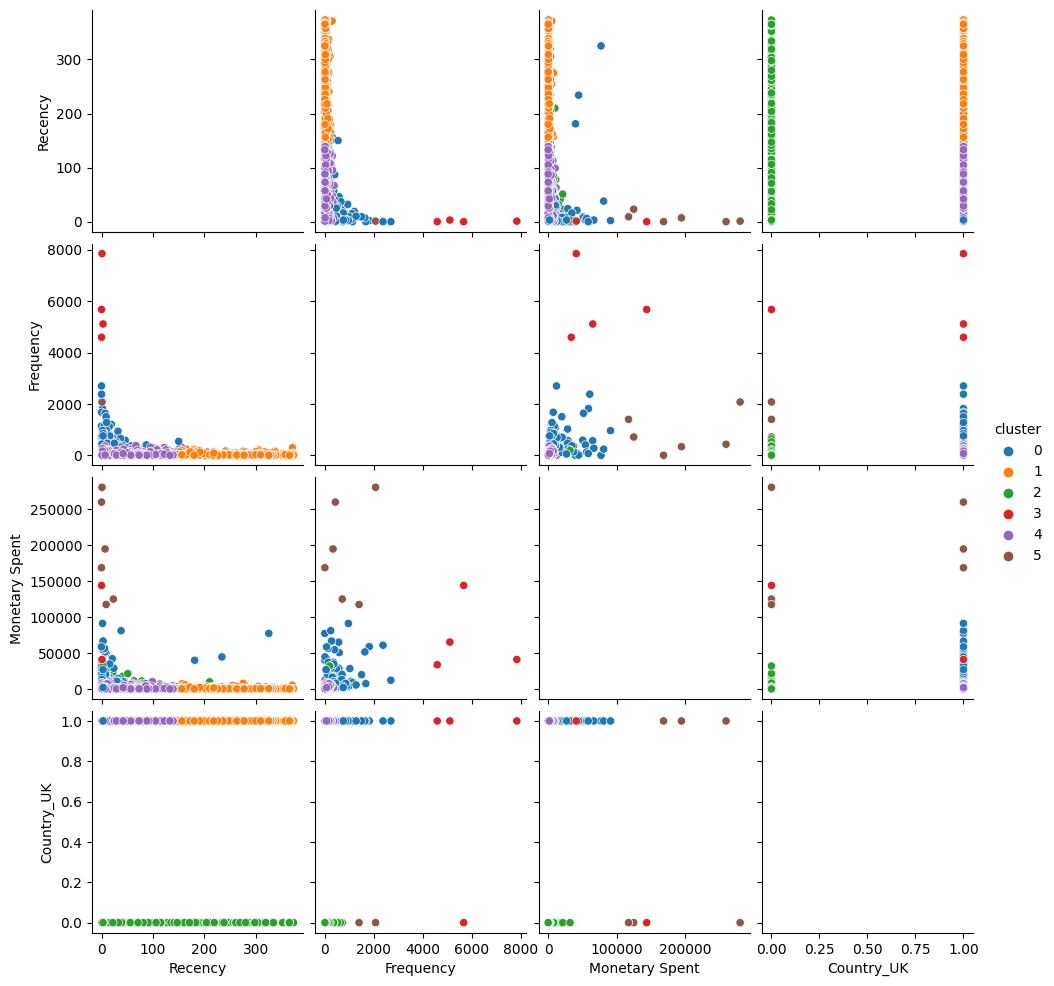

In [ ]:
kmeans = KMeans(n_clusters=6,random_state=42).fit(df_scaled)

df_result_kmeans = df_new.copy()
df_result_kmeans['cluster'] = kmeans.labels_

sns.pairplot(
    data=df_result_kmeans,
    hue='cluster',
    diag_kind='None',
    palette='tab10'
)

plt.show();

In [ ]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
(
    df_result_kmeans
    .drop("Country_UK", axis = 1)
    .groupby('cluster')
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max'])
    .transpose()
)

cluster                           0            1             2              3  \
Recency        mean       15.234973   246.776618     95.405797       1.000000   
               std        35.305176    65.636727    104.638705       1.414214   
               min         0.000000   143.000000      0.000000       0.000000   
               q25         2.000000   189.000000     18.000000       0.000000   
               median      6.000000   242.000000     52.000000       0.500000   
               q75        16.000000   296.000000    136.500000       1.500000   
               max       325.000000   373.000000    373.000000       3.000000   
Frequency      mean      535.360656    27.689979     81.396135    5807.000000   
               std       358.078267    32.176026     96.304061    1429.730044   
               min         1.000000     1.000000      1.000000    4595.000000   
               q25       367.000000     8.250000     21.250000    4982.000000   
               median    450.000000    18.000000     45.000000    5393.000000   
               q75       589.500000    33.000000    101.000000    6218.000000   
               max      2700.000000   297.000000    638.000000    7847.000000   
Monetary Spent mean    13085.065738   450.793070   2262.538913   70925.287500   
               std     16313.461152   610.367153   3479.689136   50424.336433   
               min      1093.650000     3.750000     51.560000   33719.730000   
               q25      4014.945000   163.225000    459.650000   39173.610000   
               median   6923.130000   305.515000   1025.700000   53078.180000   
               q75     13213.210000   505.542500   2659.962500   84829.857500   
               max     91062.380000  7832.470000  31906.820000  143825.060000   

cluster                           4              5  
Recency        mean       42.676884       6.666667  
               std        36.313016       8.869423  
               min         0.000000       0.000000  
               q25        14.000000       0.250000  
               median     31.000000       4.000000  
               q75        64.000000       8.500000  
               max       155.000000      23.000000  
Frequency      mean       76.270826     826.833333  
               std        74.030983     771.620481  
               min         1.000000       3.000000  
               q25        22.000000     360.500000  
               median     51.000000     572.500000  
               q75       107.000000    1228.500000  
               max       385.000000    2076.000000  
Monetary Spent mean     1341.293935  190863.461667  
               std      1592.871914   67791.993010  
               min         6.200000  117379.630000  
               q25       371.700000  135804.022500  
               median    795.120000  181511.645000  
               q75      1720.300000  243380.672500  
               max     17654.540000  280206.020000

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Recency"].count()

cluster  Country_UK
0        True           183
1        True           958
2        False          414
3        False            1
         True             3
4        True          2773
5        False            3
         True             3
Name: Recency, dtype: int64

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Frequency"].count()

cluster  Country_UK
0        True           183
1        True           958
2        False          414
3        False            1
         True             3
4        True          2773
5        False            3
         True             3
Name: Frequency, dtype: int64

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Monetary Spent"].count()

cluster  Country_UK
0        True           183
1        True           958
2        False          414
3        False            1
         True             3
4        True          2773
5        False            3
         True             3
Name: Monetary Spent, dtype: int64

That's it! The customer's behavior really segmented by their country of origin.

What if we separate the customer by its country of origin before doing cluster analysis?

# Question

1. (30 point) Lakukan EDA lebih mendalam dari data yang tersedia. Misalnya: a) Siapa top 5 customer dengan pembelian terbanyak? b) Kapan waktu pembelian dengan jumlah customer terbanyak? (Misal hari apa, jam berapa, bulan apa, minggu ke berapa, dst). EDA juga bisa dilakukan menggunakan business question lain.
2. (30 point) Apa karakteristik/ciri utama dari masing-masing cluster? Apa promo yang kira-kira cocok untuk diberikan ke masing-masing cluster?
3. (40 point) Bagaimana jika segmentation difokuskan untuk customer di luar UK? Apakah terdapat insight yang menarik? Apa karakteristik utama dari cluster-cluster non UK?

#Jawaban Question 1

##a) Siapa top 5 customer dengan pembelian terbanyak?

In [ ]:
# Total pembelian setiap customer
total_purchase = df.groupby('CustomerID')['TotalAmount'].sum()

# Top 5 customer dengan pembelian terbanyak
top_5_customers = total_purchase.sort_values(ascending=False).head(5)

# Tampilkan hasil
print("Top 5 Customer dengan Pembelian Terbanyak:")
print(top_5_customers)

Top 5 Customer dengan Pembelian Terbanyak:
CustomerID
14646.0    280206.02
18102.0    259657.30
17450.0    194550.79
16446.0    168472.50
14911.0    143825.06
Name: TotalAmount, dtype: float64


##b) Kapan waktu pembelian dengan jumlah customer terbanyak?

In [ ]:
# Menambahkan kolom bulan, hari, dan jam
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['Hour'] = df['InvoiceDate'].dt.hour

# Pembelian per jam
purchase_per_hour = df.groupby('Hour')['InvoiceNo'].nunique()
purchase_per_hour

Jam dengan Jumlah Pembelian Terbanyak: 12


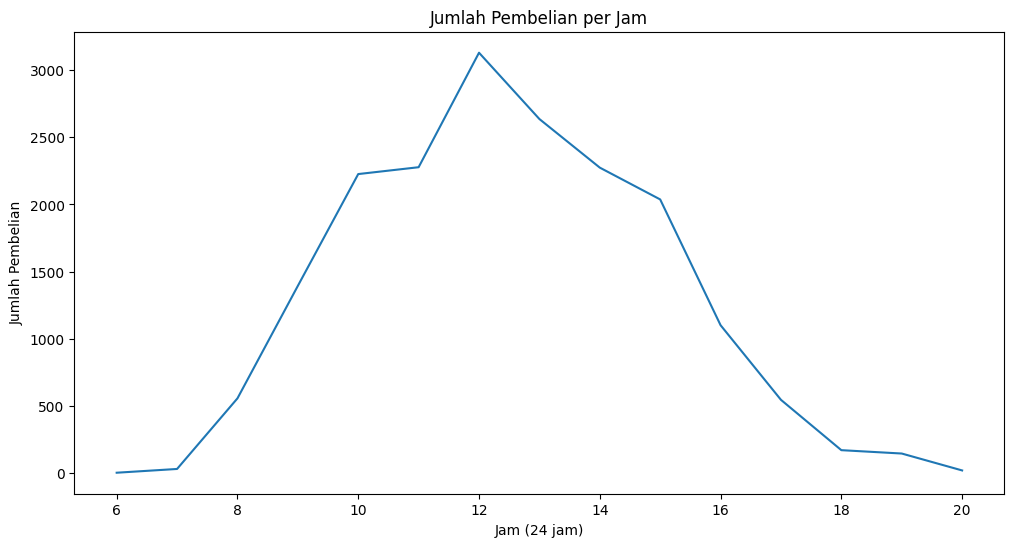

In [ ]:
# Jam dengan jumlah customer terbanyak
most_purchased_hour = purchase_per_hour.idxmax()

# Tampilkan hasil
print("Jam dengan Jumlah Pembelian Terbanyak:", most_purchased_hour)

# Visualisasi pembelian per jam
plt.figure(figsize=(12, 6))
sns.lineplot(x=purchase_per_hour.index, y=purchase_per_hour.values)
plt.title('Jumlah Pembelian per Jam')
plt.xlabel('Jam (24 jam)')
plt.ylabel('Jumlah Pembelian')
plt.show()

#Jawaban Question 2

In [ ]:
# Menambahkan label cluster ke dataframe
df_new['Cluster'] = kmeans.labels_

# Statistik deskriptif untuk masing-masing cluster
cluster_stats = (
    df_new
    .groupby('Cluster')
    .agg({
        'Recency': ['mean', 'std', 'min', 'max'],
        'Frequency': ['mean', 'std', 'min', 'max'],
        'Monetary Spent': ['mean', 'std', 'min', 'max']
    })
)

print("Statistik Deskriptif untuk Masing-masing Cluster:")
print(cluster_stats)

Statistik Deskriptif untuk Masing-masing Cluster:
            Recency                          Frequency                     \
               mean         std  min  max         mean          std   min   
Cluster                                                                     
0         15.234973   35.305176    0  325   535.360656   358.078267     1   
1        246.776618   65.636727  143  373    27.689979    32.176026     1   
2         95.405797  104.638705    0  373    81.396135    96.304061     1   
3          1.000000    1.414214    0    3  5807.000000  1429.730044  4595   
4         42.676884   36.313016    0  155    76.270826    74.030983     1   
5          6.666667    8.869423    0   23   826.833333   771.620481     3   

              Monetary Spent                                      
          max           mean           std        min        max  
Cluster                                                           
0        2700   13085.065738  16313.461152    1093.65  

Kita dapat merancang promo yang sesuai dengan karakteristik tersebut. Sebagai contoh:
- cluster 0 (recency rendah, frequency menengah, monetary menengah), promo voucher undian tiap kelipatan jumlah belanja tertentu
- cluster 1 (recency tinggi, frequency rendah, monetary rendah), promo voucher potongan harga untuk pembelian kedua, voucher ada expired date pendek
- cluster 2 (recency menengah, frequency rendah, monetary rendah), promo tebus murah untuk setiap pembelian jumlah total belanja tertentu
- cluster 3 (recency rendah, frequency tinggi, monetary menengah), promo loyalitas (hadiah menarik atau potongan harga)
- cluster 4 (recency rendah, frequency rendah, monetary rendah), promo kumpulkan point, bisa ditukar dengan hadiah menarik atau voucher
- cluster 5 (recency rendah, frequency menengah, monetary tinggi), promo diskon eksklusif/istimewa

#Jawaban Question 3

In [ ]:
# Filter data untuk customer di luar UK
df_non_uk = df[df['Country_isUK'] == 'Non UK']

# Membuat ulang dataframe untuk segmentasi non-UK
recency_non_uk = df_non_uk.groupby('CustomerID')['InvoiceDate'].max()
recency_non_uk = max(recency_non_uk) - recency_non_uk
recency_non_uk = recency_non_uk.dt.days
recency_non_uk = recency_non_uk.rename('Recency')

frequency_non_uk = df_non_uk.groupby('CustomerID')['InvoiceNo'].count()
frequency_non_uk = frequency_non_uk.rename('Frequency')

monetary_non_uk = df_non_uk.groupby('CustomerID')['TotalAmount'].sum()
monetary_non_uk = monetary_non_uk.rename('Monetary Spent')

country_non_uk = (
    df_non_uk.groupby(['CustomerID', 'Country_isUK'])
    .size()
    .reset_index()
    .drop(0, axis=1)
)

df_non_uk_new = (
    country_non_uk
    .merge(recency_non_uk, on='CustomerID')
    .merge(frequency_non_uk, on='CustomerID')
    .merge(monetary_non_uk, on='CustomerID')
)

df_non_uk_new = df_non_uk_new.set_index('CustomerID')

#Recode non-numeric variable
df_non_uk_new = pd.get_dummies(
    df_non_uk_new,
    columns=['Country_isUK'],
    drop_first=False
)

df_non_uk_new = df_non_uk_new.rename(
    columns={'Country_isUK_Non UK': 'Country_Non UK'}
)

# Pilih fitur-fitur numerik untuk scaling
numeric_features = ['Recency', 'Frequency', 'Monetary Spent']

# Skala data
scaler = StandardScaler()
df_non_uk_scaled = scaler.fit_transform(df_non_uk_new[numeric_features])#
df_non_uk_scaled = pd.DataFrame(
    df_non_uk_scaled, columns=numeric_features,
    index=df_non_uk_new.index
    )##

# Menambahkan label cluster untuk customer di luar UK
kmeans_non_uk = KMeans(n_clusters=2, random_state=42).fit(df_non_uk_scaled)
df_non_uk_new['Cluster'] = kmeans_non_uk.labels_

# Statistik deskriptif untuk masing-masing cluster non-UK
cluster_non_uk_stats = (
    df_non_uk_new
    .groupby('Cluster')
    .agg({
        'Recency': ['mean', 'std', 'min', 'max'],
        'Frequency': ['mean', 'std', 'min', 'max'],
        'Monetary Spent': ['mean', 'std', 'min', 'max'],
        'Country_Non UK': 'sum'  # Menambahkan fitur Country_Non UK pada statistik deskriptif
    })
)

print("Statistik Deskriptif untuk Masing-masing Cluster Non-UK:")
pd.DataFrame(cluster_non_uk_stats)

Statistik Deskriptif untuk Masing-masing Cluster Non-UK:


Recency                         Frequency                           \
              mean         std min  max         mean          std   min   max   
Cluster                                                                         
0        95.024038  104.532139   0  373    86.086538   119.840344     1  1400   
1         0.500000    0.707107   0    1  3875.500000  2544.877305  2076  5675   

        Monetary Spent                                     Country_Non UK  
                  mean           std        min        max            sum  
Cluster                                                                    
0          2834.099207   8938.916929      51.56  124914.53            416  
1        212015.540000  96435.901641  143825.06  280206.02              2

Berdasarkan hasil output dari analisis karakteristik utama dari masing-masing cluster non UK, berikut adalah beberapa kesimpulan yang dapat diambil:

Terdapat 2 cluster, yaitu:
*   Cluster 0 (Recency menengah, Frequency rendah dan Monetary rendah) sebanyak 416. Ini artinya lesu, harus digalakan promo tebus murah untuk setiap pembelian jumlah total belanja tertentu
*   Cluster 1 (Recency rendah, Frequency tinggi dan Monetary tinggi) hanya 2. Untuk cluster ini sangat bagus sekali, sayang cuma 2. Untuk promo paling promo ekslusif tapi yang terpenting untuk customer ini adalah servis harus ok karena lebih ke arah maintenance customer atau kepuasan pelanggan.